# Linear Classification with Gradient Descent

In [20]:
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
import data_handler as dh
from matplotlib import pyplot as plt

## Fetching and Pre-Processing the data

In [21]:
bank_marketing = fetch_ucirepo(id=222)
occupancy_detection = fetch_ucirepo(id=357)

X_bank_marketing, y_bank_marketing = bank_marketing.data.features, bank_marketing.data.targets
X_occupancy, y_occupancy = occupancy_detection.data.features, occupancy_detection.data.targets

Pre-process the bank marketing data. Drop features without values for prediction: month, day_of_week. We have to treat NaN values differently than last week, since dropping them would drastically reduce the instances of the data, so we replace them with 0. We use One-Hot encoding for non-numeric (categorical) values. We use min-max normalization to avoid huge values for residuals.

In [22]:
X_bank_marketing = X_bank_marketing.drop(['month', 'day_of_week'], axis=1)  # drop features without value for prediction

X_bank_marketing = X_bank_marketing.fillna(0)

X_bank_marketing = pd.get_dummies(X_bank_marketing).astype(np.float64)

X_bank_marketing = (X_bank_marketing - X_bank_marketing.min()) / (
        X_bank_marketing.max() - X_bank_marketing.min())  # normalize the data

y_bank_marketing.loc[:, 'y'] = y_bank_marketing['y'].map({'no': 0, 'yes': 1})  # convert targets to numeric values

Pre-process the occupancy data. Drop the date feature. Since all features are type object, we have to remove the standing out ones and convert them to numeric values. We use min-max normalization to avoid huge values for residuals.

In [23]:
X_occupancy = X_occupancy.drop(['date'], axis=1)  # drop features without value for prediction

X_occupancy = X_occupancy.apply(pd.to_numeric, errors='coerce').dropna().astype(
    np.float64)  # Convert all columns to numeric, coerce errors to NaN, and drop rows with NaN values

X_occupancy = (X_occupancy - X_occupancy.min()) / (X_occupancy.max() - X_occupancy.min())  # normalize the data

Split the datasets in training data and test data. We use our method from `data_handler`.

In [24]:
X_occupancy_train, X_occupancy_test, y_occupancy_train, y_occupancy_test = dh.split_data(X_occupancy,
                                                                                         y_occupancy, 0.8)
X_bank_marketing_train, X_bank_marketing_test, y_bank_marketing_train, y_bank_marketing_test = dh.split_data(
    X_bank_marketing, y_bank_marketing, 0.8)

## Implementation of Linear Classification

We use the negative log likelihood function, else we would have only negative loss values.
We use the epoch loss difference for convergence criterion


In [33]:
class LinearClassifier:
    def __init__(self):
        self.B = None

    def fit(self, X_train, y_train, X_test, y_test, i_max, tolerance=1e-6):
        """
        Fits the model using the stochastic gradient descent/ascend algorithm.
        :param X_train: Training input features.
        :param y_train: Training target values.
        :param X_test: Test input features for calculating the log-loss.
        :param y_test: Test target values for calculating the log-loss.
        :param i_max: Maximum number of iterations.
        :param tolerance: Improvement threshold for convergence.
        :return: Tuple of epoch loss difference history (|f(x_i-1 - f(x_i)|) and log-loss history on test set.
        """
        initial_learning_rate = 0.01
        alpha = 1.1
        beta = 0.5

        n = X_train.shape[0]
        d = X_train.shape[1]

        def SGD(f, grad_f):
            self.B = np.zeros(d)
            learning_rate = initial_learning_rate
            epoch_loss_diff = []
            test_loss_history = []

            for epoch in range(1, i_max + 1):
                indices = np.random.permutation(n)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                prev_loss = f(X_train, y_train)

                for i in range(n):
                    x_i = X_shuffled[i]
                    y_i = y_shuffled[i]

                    gradient = grad_f(x_i, y_i)

                    self.B += learning_rate * gradient

                current_loss = f(X_train, y_train)
                loss_diff = abs(current_loss - prev_loss)
                epoch_loss_diff.append(loss_diff)

                test_loss = f(X_test, y_test)
                test_loss_history.append(test_loss)

                # bold driver for choosing the step length
                if current_loss < prev_loss:
                    learning_rate *= alpha
                else:
                    learning_rate *= beta

                if len(epoch_loss_diff) > 1 and epoch_loss_diff[-1] < tolerance:
                    print(f"Converged after {epoch} epochs.")
                    break
            else:
                print(f"WARNING: Not converged after {i_max} epochs.")
            return epoch_loss_diff, test_loss_history

        def log_likelihood(X, y):
            predictions = 1 / (1 + np.exp(-(X @ self.B)))
            return -np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions)) / X.shape[0]  # Normalized loss

        def grad_log_likelihood(x_i, y_i):
            sigmoid = 1 / (1 + np.exp(-(self.B.T @ x_i)))
            return (y_i - sigmoid) * x_i

        return SGD(log_likelihood, grad_log_likelihood)

    def predict(self, X):
        """
        Predicts the target values.
        :param X: Input features.
        :return: Predicted values.
        """
        if self.B is None:
            raise ValueError('The Model has not been trained yet. Please call fit() first.')

        sigmoid = 1 / (1 + np.exp(-(self.B.T @ X)))

        return (sigmoid >= 0.5).astype(np.int8)  # Threshold of 0.5 to convert to binary values


In [36]:
model = LinearClassifier()
eld, tlh = model.fit(X_bank_marketing_train, y_bank_marketing_train, X_bank_marketing_test, y_bank_marketing_test, 500,
                     tolerance=1e-7)

Converged after 65 epochs.


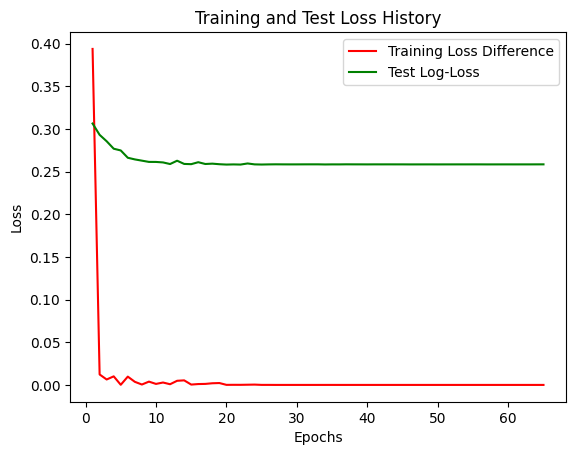

In [39]:
plt.plot(range(1, len(eld) + 1), eld, label="Training Loss Difference", color="red")
plt.plot(range(1, len(tlh) + 1), tlh, label="Test Log-Loss", color="green")

plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.yscale('log')
plt.title('Training and Test Loss History')
plt.legend()
plt.show()
plt.close()